In [1]:
import json
import os
import pickle
import warnings

import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

from utils.data_utils import (DynamicBatchSampler, collate_fn, get_dataset,
                              get_grouping, get_static_dataset,
                              get_test_dataset, get_test_synthetic_dataset)
from utils.optuna_utils import load_best_model
from utils.result_utils import (inference, plot_3d_combined_pdfs, plot_pdf,
                                report_results)
from utils.train_utils import ComparisonQuantileLoss, TwoStageQuantileLoss, train
from LinearRegression import LinearQuantileRegression

with open("config.json", "r") as f:
    config = json.load(f)

quantiles = config["general"]["quantiles"]
validation_start_date = config["general"]["dates"]["validation_period"]["start_date"]
validation_end_date = config["general"]["dates"]["validation_period"]["end_date"]
test_start_date = config["general"]["dates"]["test_period"]["start_date"]
test_end_date = config["general"]["dates"]["test_period"]["end_date"]
loss_fn = TwoStageQuantileLoss(quantiles)
test_loss_fn = ComparisonQuantileLoss(quantiles)
results = {}

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

warnings.filterwarnings("ignore")

if not os.path.exists("plots"):
    os.makedirs("plots")

In [2]:
lstm_model, lstm_params = load_best_model('lstm')

lstm_model.to(DEVICE)

lstm_normalization_window = lstm_params['normalazation_window']
lstm_batch_size = lstm_params['batch_size']
l1_reg = lstm_params['l1_reg']
l2_reg = lstm_params['l2_reg']

lstm_optimizer = torch.optim.Adam(lstm_model.parameters(
), lr=lstm_params['learning_rate'], weight_decay=l2_reg)

print(lstm_model)
print(f"Model has {sum(p.numel() for p in lstm_model.parameters() if p.requires_grad)} parameters")

LSTM_Model(
  (normalize_lstm): LSTM(49, 64, num_layers=4, batch_first=True, dropout=0.10226695393130666)
  (normalize_module): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.10226695393130666, inplace=False)
    (4): Linear(in_features=128, out_features=37, bias=True)
  )
  (market_lstm): LSTM(21, 128, batch_first=True, dropout=0.10226695393130666)
  (market_module): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): Dropout(p=0.10226695393130666, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)
Model has 228390 parameters


In [3]:
lstm_params

{'batch_size': 256,
 'learning_rate': 0.00043591898946257636,
 'normalazation_window': 34,
 'raw_lstm_layers': 4,
 'raw_lstm_h': 64,
 'raw_hidden_layers': 1,
 'raw_hidden_layer_0': 128,
 'market_lstm_layers': 1,
 'market_lstm_h': 128,
 'market_hidden_layers': 1,
 'market_hidden_layer_0': 64,
 'dropout': 0.10226695393130666,
 'market_activation': '',
 'hidden_activation': 'leaky_relu',
 'use_layer_norm': 1,
 'l1_reg': 0.000920954975652464,
 'l2_reg': 0.000981176510932213}

In [4]:
if os.path.exists('lstm_model.pth'):
    lstm_model.load_state_dict(torch.load('lstm_model.pth'))
    lstm_model.to(DEVICE)
    print("Model loaded from lstm_model.pth")
else:
    lstm_train_dataset = get_dataset(
        lstm_normalization_window, "1998-01-01", validation_start_date)
    lstm_val_dataset = get_dataset(lstm_normalization_window,
                                   validation_start_date, validation_end_date)
    lstm_train_batch_sampler = DynamicBatchSampler(
        lstm_train_dataset, batch_size=lstm_batch_size)
    lstm_val_batch_sampler = DynamicBatchSampler(lstm_val_dataset, batch_size=lstm_batch_size)

    lstm_train_loader = DataLoader(
        lstm_train_dataset, batch_sampler=lstm_train_batch_sampler, collate_fn=collate_fn)
    lstm_val_loader = DataLoader(
        lstm_val_dataset, batch_sampler=lstm_val_batch_sampler, collate_fn=collate_fn)
    _, lstm_model = train(
        model=lstm_model,
        train_loader=lstm_train_loader,
        val_loader=lstm_val_loader,
        criterion=loss_fn,
        optimizer=lstm_optimizer,
        num_epochs=100,
        patience=10,
        l1_reg=l1_reg,
        verbose=True
    )
    torch.save(lstm_model.state_dict(), 'lstm_model.pth')

Model loaded from lstm_model.pth


In [5]:
dense_model, dense_params = load_best_model('dense')

dense_model.to(DEVICE)

dense_normalization_window = dense_params['normalazation_window']
dense_batch_size = dense_params['batch_size']
l1_reg = dense_params['l1_reg']
l2_reg = dense_params['l2_reg']

dense_optimizer = torch.optim.Adam(dense_model.parameters(), lr=dense_params['learning_rate'], weight_decay=l2_reg)

print(dense_model)

QuantileDense(
  (raw_layers): ModuleList(
    (0): Linear(in_features=49, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): Dropout(p=0.17800718285946865, inplace=False)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=64, out_features=512, bias=True)
    (5): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (6): Dropout(p=0.17800718285946865, inplace=False)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=512, out_features=37, bias=True)
  )
  (raw_model): Sequential(
    (0): Linear(in_features=49, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): Dropout(p=0.17800718285946865, inplace=False)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=64, out_features=512, bias=True)
    (5): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (6): Dropout(p=0.17800718285946865, inplace=False)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=512, out_features=37, bias=Tr

In [6]:
dense_params

{'batch_size': 2048,
 'learning_rate': 0.0006578193513455403,
 'normalazation_window': 123,
 'n_raw_hidden_layers': 2,
 'raw_hidden_layer_0': 64,
 'raw_hidden_layer_1': 512,
 'hidden_activation': 'elu',
 'n_market_hidden_layers': 4,
 'market_hidden_layer_0': 64,
 'market_hidden_layer_1': 512,
 'market_hidden_layer_2': 16,
 'market_hidden_layer_3': 32,
 'market_activation': 'sigmoid',
 'dropout': 0.17800718285946865,
 'layer_norm': 1,
 'l1_reg': 0.0007399860614560371,
 'l2_reg': 0.00035998151377661554}

In [7]:
if os.path.exists('dense_model.pth'):
    dense_model.load_state_dict(torch.load('dense_model.pth'))
    dense_model.to(DEVICE)
    print("Model loaded from dense_model.pth")
else:
    dense_train_dataset = get_static_dataset(dense_normalization_window, "1998-01-01", validation_start_date)
    dense_val_dataset = get_static_dataset(dense_normalization_window, validation_start_date, validation_end_date)

    dense_train_loader = DataLoader(dense_train_dataset, batch_size=dense_batch_size, shuffle=True)
    dense_val_loader = DataLoader(dense_val_dataset, batch_size=dense_batch_size, shuffle=False)
    _, dense_model = train(
        model=dense_model,
        train_loader=dense_train_loader,
        val_loader=dense_val_loader,
        criterion=loss_fn,
        optimizer=dense_optimizer,
        num_epochs=100,
        patience=10,
        l1_reg=l1_reg,
        verbose=True
    )
    torch.save(dense_model.state_dict(), 'dense_model.pth')

Model loaded from dense_model.pth


In [8]:
if not os.path.exists("quant_reg.pth"):
    dense_train_dataset = get_static_dataset(dense_normalization_window, "1998-01-01", validation_start_date)

    big_X = []
    big_y = []
    for i in range(len(dense_train_dataset)):
        x, _, z, y, _ = dense_train_dataset[i]
        xx = torch.cat((x, z))
        y = y.view(-1).cpu().numpy()
        big_X.append(xx.cpu().numpy())
        big_y.append(y)
    big_X = np.array(big_X)
    big_y = np.array(big_y).reshape(-1)

    quant_reg = LinearQuantileRegression(quantiles)
    quant_reg.train(big_X, big_y)

    with open("quant_reg.pth", "wb") as f:
        pickle.dump(quant_reg, f)
else:
    with open("quant_reg.pth", "rb") as f:
        quant_reg = pickle.load(f)
    print("Model loaded from quant_reg.pth")

Model loaded from quant_reg.pth


In [9]:
dense_test_dataset = get_test_dataset(dense_normalization_window, test_start_date, test_end_date)
lstm_test_dataset = get_test_dataset(lstm_normalization_window, test_start_date, test_end_date)

In [10]:
assets = dense_test_dataset.assets
datas = dense_test_dataset.datas

In [11]:
batch_size = 1024
for asset in tqdm(assets, desc='Inferencing models'):
    grouping = get_grouping(datas, asset)
    if grouping not in results:
        results[grouping] = {
            'linear': 0,
            'dense': 0,
            'lstm': 0,
        }
    dense_test_dataset.set_main_asset(asset)
    lstm_test_dataset.set_main_asset(asset)

    dense_data_loader = DataLoader(dense_test_dataset, batch_size=1024, shuffle=False)
    lstm_data_loader = DataLoader(lstm_test_dataset, batch_size=1024, shuffle=False)
    dense_losses = inference(dense_model, dense_data_loader, test_loss_fn, is_dense=True)
    lstm_losses = inference(lstm_model, lstm_data_loader, test_loss_fn, is_dense=False)
    linear_loss = inference(quant_reg, dense_data_loader, test_loss_fn, is_dense=False,
                            is_linear=True)

    results[grouping]['linear'] += linear_loss.mean().item()
    results[grouping]['dense'] += dense_losses.mean().item()
    results[grouping]['lstm'] += lstm_losses.mean().item()
results = {k: {model: value / 10 for model, value in v.items()} for k, v in results.items()}
market_results = results.copy()

Inferencing models:   0%|          | 0/60 [00:00<?, ?it/s]

In [12]:
report_results(market_results)

                  linear   dense    lstm Difference (Dense - LSTM) Difference (Linear - LSTM) Difference (Linear - Dense)
commodities       1.4850  0.6226  0.3319           0.2908 (60.93%)           1.1532 (126.94%)             0.8624 (81.83%)
cryptocurrencies  2.5176  1.3605  0.9292           0.4313 (37.68%)            1.5884 (92.17%)             1.1571 (59.67%)
s&p 500           1.4832  0.5969  0.3284           0.2684 (58.02%)           1.1547 (127.48%)             0.8863 (85.22%)
nikkei 225        1.4805  0.6187  0.3298           0.2889 (60.92%)           1.1507 (127.13%)             0.8618 (82.11%)
euro stoxx 50     1.4803  0.5983  0.3326           0.2656 (57.07%)           1.1477 (126.61%)             0.8821 (84.87%)
currency pairs    1.2086  0.1597  0.1156           0.0441 (32.05%)           1.0930 (165.09%)            1.0489 (153.32%)
Total Mean        1.6092  0.6594  0.3946           0.2649 (50.26%)           1.2146 (121.23%)             0.9498 (83.73%)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


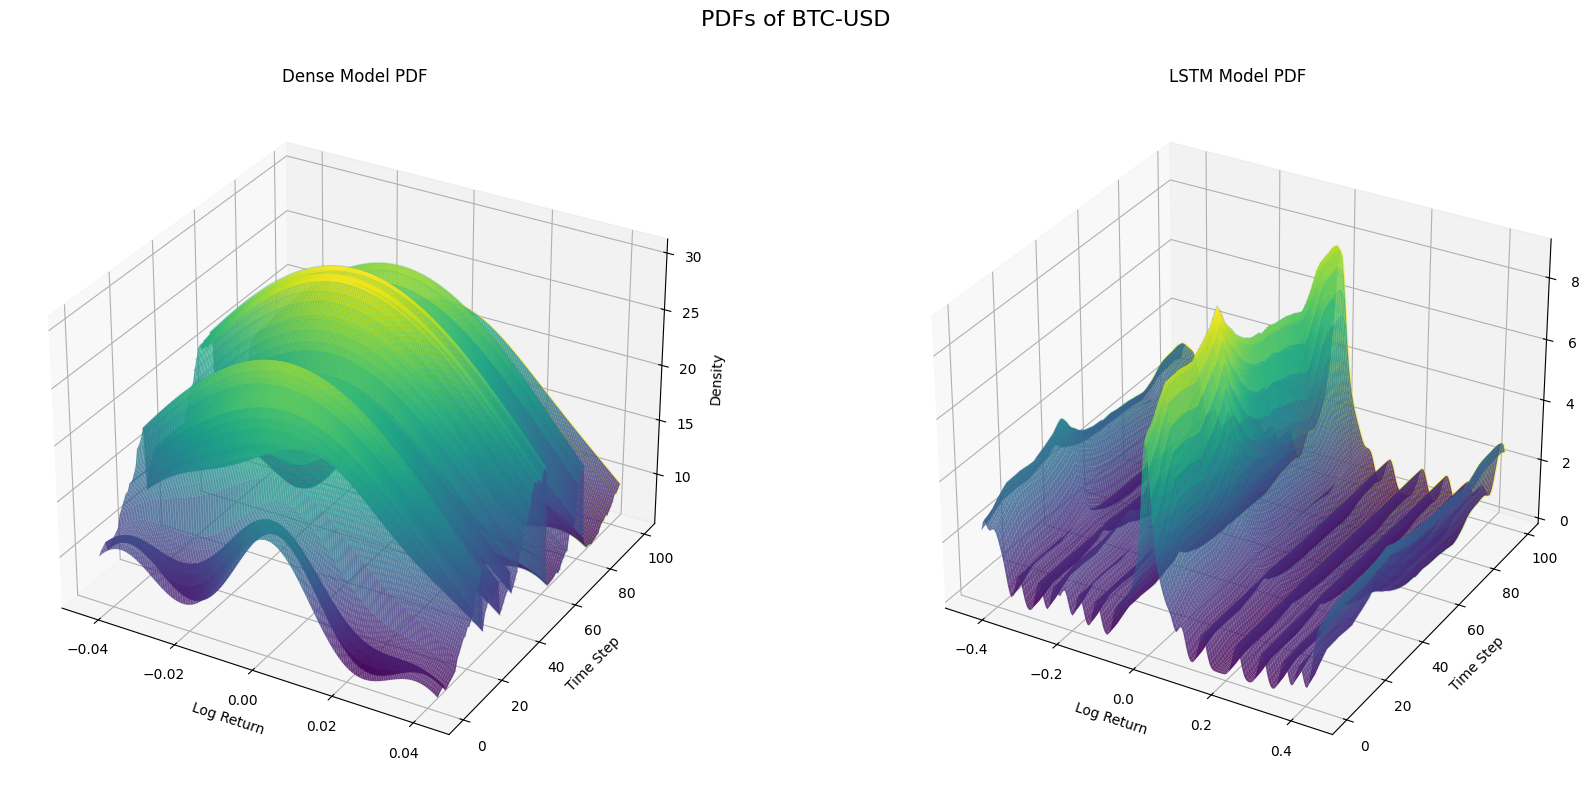

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


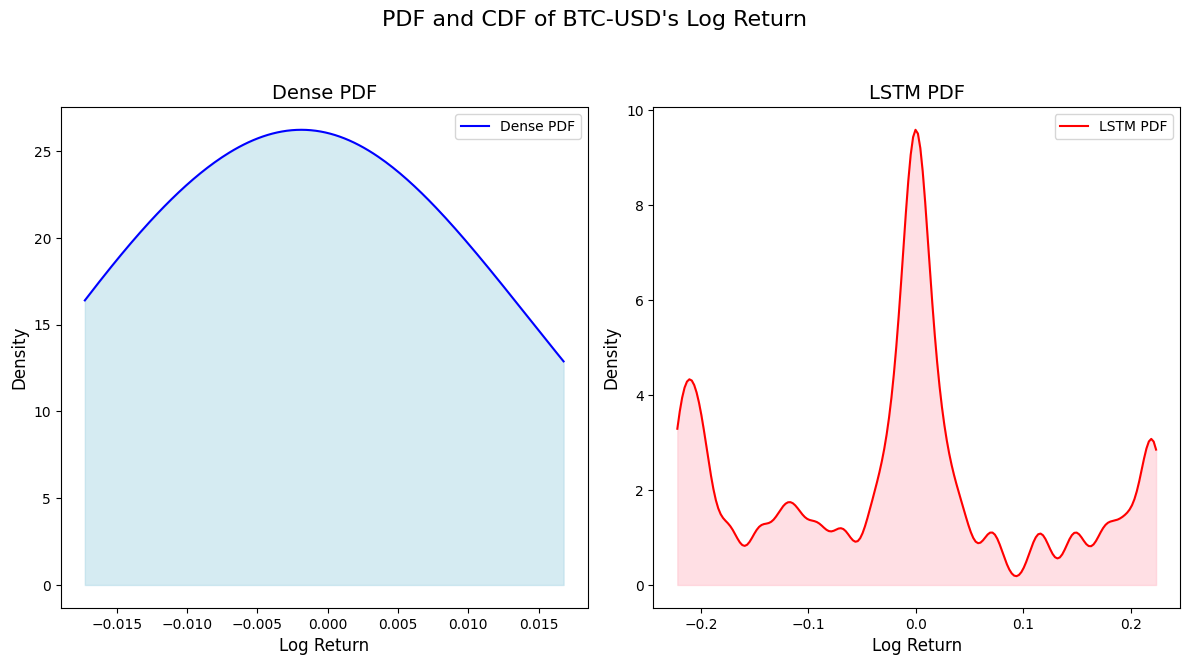

In [13]:
plot_3d_combined_pdfs('BTC-USD', dense_model, lstm_model, quant_reg,
                      dense_test_dataset, lstm_test_dataset, is_linear=False)
plot_pdf('BTC-USD', dense_model, lstm_model, quant_reg,
         dense_test_dataset, lstm_test_dataset, is_linear=False)

In [14]:
print("Generating Normally Distributed Test Dataset")
dense_normal_test_dataset, lstm_normal_test_dataset = get_test_synthetic_dataset(
    dense_normalization_window, lstm_normalization_window, 1000, 0.7, distribution='normal')
print("Generating Log Normally Distributed Test Dataset")
dense_log_normal_test_dataset, lstm_log_normal_test_dataset = get_test_synthetic_dataset(
    dense_normalization_window, lstm_normalization_window, 1000, 0.7, distribution='lognormal')
print("Generating Gamma Distributed Test Dataset")
dense_gamma_test_dataset, lstm_gamma_test_dataset = get_test_synthetic_dataset(
    dense_normalization_window, lstm_normalization_window, 1000, 0.7, distribution='gamma')
print("Generating Uniform Distributed Test Dataset")
dense_uniform_test_dataset, lstm_uniform_test_dataset = get_test_synthetic_dataset(
    dense_normalization_window, lstm_normalization_window, 1000, 0.7, distribution='uniform')

synthetic_data = {
    'Normal': (dense_normal_test_dataset, lstm_normal_test_dataset),
    'Log Normal': (dense_log_normal_test_dataset, lstm_log_normal_test_dataset),
    'Gamma': (dense_gamma_test_dataset, lstm_gamma_test_dataset),
    'Uniform': (dense_uniform_test_dataset, lstm_uniform_test_dataset)
}

Generating Normally Distributed Test Dataset
Generated mu: -0.000663, sigma: 0.022852
Generated mu: -0.000944, sigma: 0.027103
Generated mu: 0.000427, sigma: 0.010072
Generated mu: -0.000551, sigma: 0.020746
Generated mu: -0.000796, sigma: 0.023492
Generated mu: -0.000633, sigma: 0.018013
Generated mu: 0.000044, sigma: 0.028276
Generated mu: -0.000502, sigma: 0.017238
Generated mu: 0.000452, sigma: 0.021794
Generated mu: 0.000647, sigma: 0.012101
Asset 1 correlation with market data: 0.7047
Asset 2 correlation with market data: 0.6787
Asset 3 correlation with market data: 0.7149
Asset 4 correlation with market data: 0.6908
Asset 5 correlation with market data: 0.7261
Asset 6 correlation with market data: 0.7077
Asset 7 correlation with market data: 0.6712
Asset 8 correlation with market data: 0.6884
Asset 9 correlation with market data: 0.7028
Asset 10 correlation with market data: 0.6820
Generating Log Normally Distributed Test Dataset
Generated mu: 0.000922, sigma: 0.015048
Generated

In [15]:
synthetic_results = {}
for distribution, (dense_synthetic_test_dataset, lstm_synthetic_test_dataset) in tqdm(synthetic_data.items(), desc='Inferencing synthetic datasets'):
    dense_total_loss = 0
    lstm_total_loss = 0
    for i in range(0, 10):
        dense_synthetic_test_dataset.set_main_asset(f"synthetic_{i}")
        lstm_synthetic_test_dataset.set_main_asset(f"synthetic_{i}")
        dense_data_loader = DataLoader(dense_synthetic_test_dataset, batch_size=1024, shuffle=False)
        lstm_data_loader = DataLoader(lstm_synthetic_test_dataset, batch_size=1024, shuffle=False)
        linear_losses = inference(quant_reg, dense_data_loader,
                                  test_loss_fn, is_dense=False, is_linear=True)
        dense_losses = inference(dense_model, dense_data_loader, test_loss_fn, is_dense=True)
        lstm_losses = inference(lstm_model, lstm_data_loader, test_loss_fn, is_dense=False)
        dense_total_loss += dense_losses.mean().item()
        lstm_total_loss += lstm_losses.mean().item()

    dense_total_loss /= 10
    lstm_total_loss /= 10

    results[f"{distribution} synthetic"] = {
        'linear': linear_losses.mean().item(),
        'dense': dense_total_loss,
        'lstm': lstm_total_loss
    }
    synthetic_results[f"{distribution} synthetic"] = {
        'linear': linear_losses.mean().item(),
        'dense': dense_total_loss,
        'lstm': lstm_total_loss
    }

Inferencing synthetic datasets:   0%|          | 0/4 [00:00<?, ?it/s]

In [16]:
report_results(synthetic_results)

                      linear   dense    lstm Difference (Dense - LSTM) Difference (Linear - LSTM) Difference (Linear - Dense)
Normal synthetic      0.2400  0.7003  0.3549           0.3454 (65.46%)          -0.1149 (-38.62%)           -0.4603 (-97.89%)
Log Normal synthetic  0.4163  0.7075  0.3713           0.3362 (62.33%)            0.0450 (11.43%)           -0.2912 (-51.82%)
Gamma synthetic       0.5124  0.7392  0.3805           0.3586 (64.06%)            0.1318 (29.53%)           -0.2268 (-36.24%)
Uniform synthetic     0.2188  0.5683  0.2993           0.2691 (62.03%)          -0.0805 (-31.06%)           -0.3495 (-88.81%)
Total Mean            0.3469  0.6788  0.3515           0.3273 (63.54%)           -0.0046 (-1.32%)           -0.3319 (-64.73%)


In [17]:
report_results(results)

                      linear   dense    lstm Difference (Dense - LSTM) Difference (Linear - LSTM) Difference (Linear - Dense)
commodities           1.4850  0.6226  0.3319           0.2908 (60.93%)           1.1532 (126.94%)             0.8624 (81.83%)
cryptocurrencies      2.5176  1.3605  0.9292           0.4313 (37.68%)            1.5884 (92.17%)             1.1571 (59.67%)
s&p 500               1.4832  0.5969  0.3284           0.2684 (58.02%)           1.1547 (127.48%)             0.8863 (85.22%)
nikkei 225            1.4805  0.6187  0.3298           0.2889 (60.92%)           1.1507 (127.13%)             0.8618 (82.11%)
euro stoxx 50         1.4803  0.5983  0.3326           0.2656 (57.07%)           1.1477 (126.61%)             0.8821 (84.87%)
currency pairs        1.2086  0.1597  0.1156           0.0441 (32.05%)           1.0930 (165.09%)            1.0489 (153.32%)
Normal synthetic      0.2400  0.7003  0.3549           0.3454 (65.46%)          -0.1149 (-38.62%)           -0.4603 (-

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


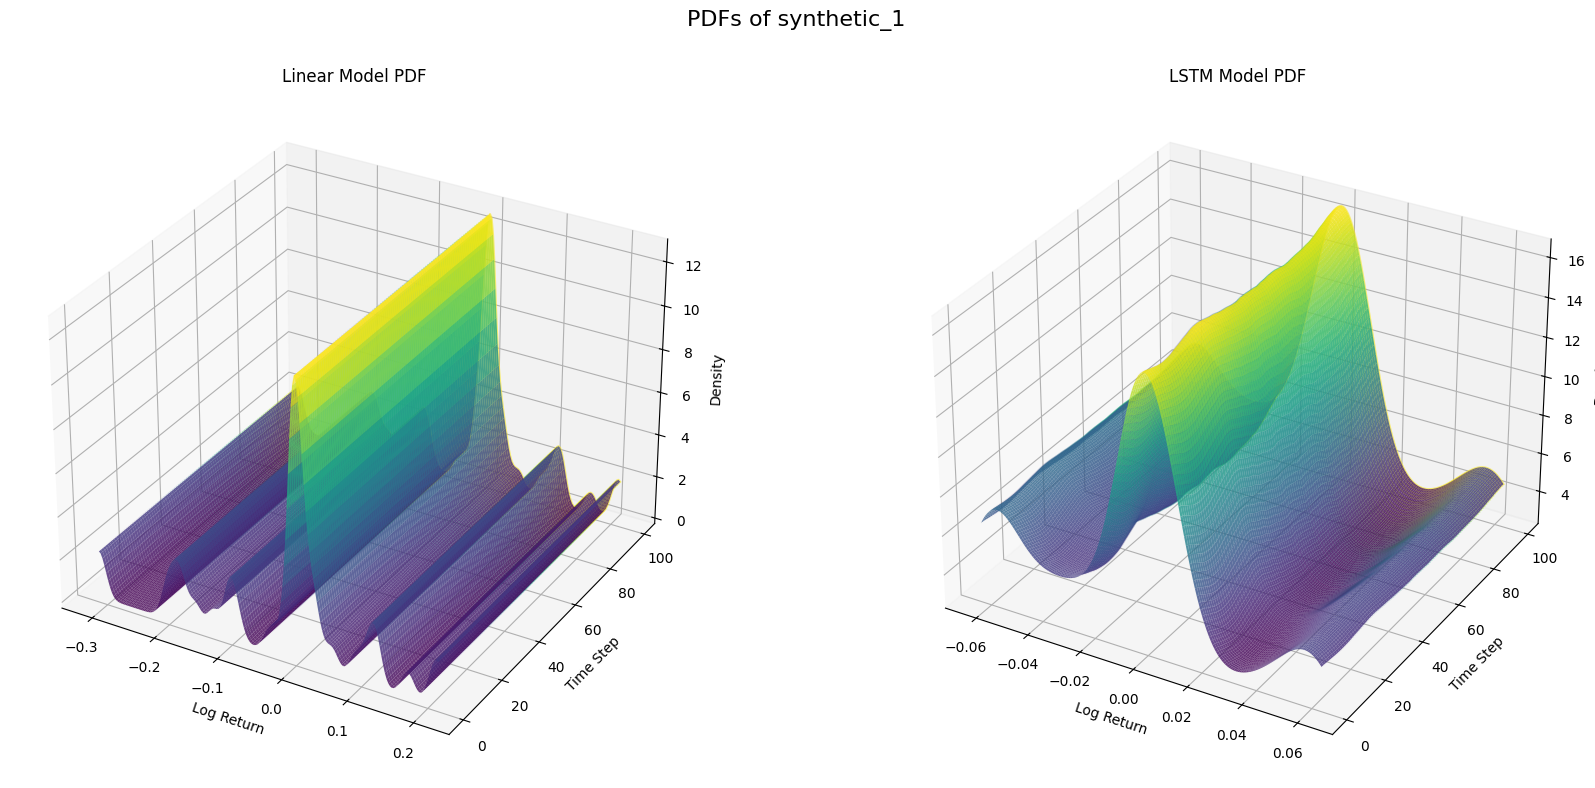

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


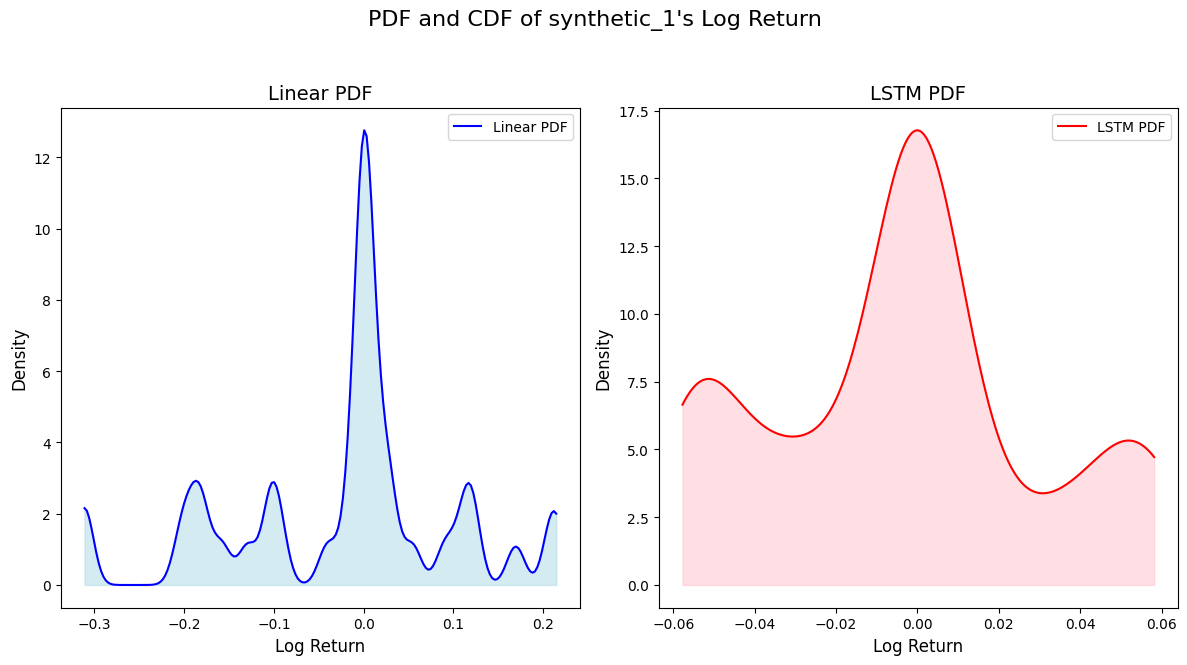

In [18]:
plot_3d_combined_pdfs('synthetic_1', dense_model, lstm_model, quant_reg, dense_normal_test_dataset, lstm_normal_test_dataset, is_linear=True)
plot_pdf('synthetic_1', dense_model, lstm_model, quant_reg, dense_normal_test_dataset, lstm_normal_test_dataset, is_linear=True)